In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# =============================================
# DEBUGGING: Check Google Drive Dataset Structure
# =============================================

import os

# Your dataset path
DATA_ROOT = "/content/drive/MyDrive/CombinedDataset"

print("=" * 60)
print("DEBUGGING DATASET STRUCTURE")
print("=" * 60)

# Check if root exists
print(f"\n1. Checking if DATA_ROOT exists: {DATA_ROOT}")
if os.path.exists(DATA_ROOT):
    print("✓ DATA_ROOT exists!")
else:
    print("✗ DATA_ROOT does NOT exist!")
    print("\nListing contents of /content/drive/MyDrive/:")
    try:
        contents = os.listdir("/content/drive/MyDrive/")
        for item in contents[:20]:  # Show first 20 items
            print(f"  - {item}")
    except Exception as e:
        print(f"Error listing MyDrive: {e}")
    print("\nPlease verify the correct folder name in your Google Drive!")
    exit()

# List immediate subdirectories
print(f"\n2. Contents of {DATA_ROOT}:")
try:
    contents = os.listdir(DATA_ROOT)
    for item in contents:
        item_path = os.path.join(DATA_ROOT, item)
        if os.path.isdir(item_path):
            print(f"  📁 {item}/")
        else:
            print(f"  📄 {item}")
except Exception as e:
    print(f"Error: {e}")

# Check for expected splits
print("\n3. Checking for train/val/test splits:")
for split in ['train', 'val', 'test']:
    split_path = os.path.join(DATA_ROOT, split)
    exists = os.path.exists(split_path)
    print(f"  {split}: {'✓ EXISTS' if exists else '✗ MISSING'}")

    if exists:
        print(f"    Contents of {split}/:")
        try:
            for item in os.listdir(split_path):
                print(f"      - {item}")
        except Exception as e:
            print(f"      Error: {e}")

# Check for mel folder structure
print("\n4. Checking mel spectrogram folder structure:")
for split in ['train', 'val', 'test']:
    mel_path = os.path.join(DATA_ROOT, split, "mel")
    if os.path.exists(mel_path):
        print(f"\n  ✓ {split}/mel/ exists")

        # Check for real/fake folders
        real_path = os.path.join(mel_path, "real")
        fake_path = os.path.join(mel_path, "fake")

        print(f"    real/: {'✓ EXISTS' if os.path.exists(real_path) else '✗ MISSING'}")
        print(f"    fake/: {'✓ EXISTS' if os.path.exists(fake_path) else '✗ MISSING'}")

        # Count .npy files
        if os.path.exists(real_path):
            npy_files = [f for f in os.listdir(real_path) if f.endswith('.npy')]
            print(f"      real/ has {len(npy_files)} .npy files")
            if len(npy_files) > 0:
                print(f"      Example: {npy_files[0]}")

        if os.path.exists(fake_path):
            npy_files = [f for f in os.listdir(fake_path) if f.endswith('.npy')]
            print(f"      fake/ has {len(npy_files)} .npy files")
            if len(npy_files) > 0:
                print(f"      Example: {npy_files[0]}")
    else:
        print(f"\n  ✗ {split}/mel/ does NOT exist")
        # Show what's actually in the split folder
        split_path = os.path.join(DATA_ROOT, split)
        if os.path.exists(split_path):
            print(f"    Contents of {split}/:")
            for item in os.listdir(split_path):
                print(f"      - {item}")

# Alternative: Check if files are directly in split folders
print("\n5. Checking for alternative structure (files directly in split folders):")
for split in ['train', 'val', 'test']:
    split_path = os.path.join(DATA_ROOT, split)
    if os.path.exists(split_path):
        all_files = []
        for root, dirs, files in os.walk(split_path):
            for f in files:
                if f.endswith('.npy'):
                    all_files.append(os.path.join(root, f))

        print(f"  {split}/: Found {len(all_files)} total .npy files")
        if len(all_files) > 0:
            print(f"    First 3 file paths:")
            for fp in all_files[:3]:
                print(f"      {fp}")

print("\n" + "=" * 60)
print("DEBUGGING COMPLETE")
print("=" * 60)

DEBUGGING DATASET STRUCTURE

1. Checking if DATA_ROOT exists: /content/drive/MyDrive/CombinedDataset
✓ DATA_ROOT exists!

2. Contents of /content/drive/MyDrive/CombinedDataset:
  📁 test/
  📁 val/
  📁 logs/
  📁 train/
  📁 results_resnet18/

3. Checking for train/val/test splits:
  train: ✓ EXISTS
    Contents of train/:
      - mel
      - audio
  val: ✓ EXISTS
    Contents of val/:
      - mel
      - audio
  test: ✓ EXISTS
    Contents of test/:
      - mel
      - audio

4. Checking mel spectrogram folder structure:

  ✓ train/mel/ exists
    real/: ✓ EXISTS
    fake/: ✓ EXISTS
      real/ has 10480 .npy files
      Example: LJ001-0056.npy
      fake/ has 10480 .npy files
      Example: gen_9924.npy

  ✓ val/mel/ exists
    real/: ✓ EXISTS
    fake/: ✓ EXISTS
      real/ has 1310 .npy files
      Example: LJ028-0487.npy
      fake/ has 1310 .npy files
      Example: LJ014-0110.npy

  ✓ test/mel/ exists
    real/: ✓ EXISTS
    fake/: ✓ EXISTS
      real/ has 1310 .npy files
      Exam

In [24]:
# =============================================
# AUDIO DEEPFAKE DETECTION: RESNET-18 + MEL SPECTROGRAMS
# Complete Training Pipeline with Mixed Precision Training
# =============================================

print("installing required packages")
!pip install -q torch torchvision torchaudio scikit-learn tqdm

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

class Config:
    # Paths
    # Use Google Drive storage
    DATA_ROOT = "/content/drive/MyDrive/CombinedDataset"
    OUT_DIR = f"{DATA_ROOT}/results_resnet18"
    #DATA_ROOT = "/content/CombinedDataset"  # Using local storage
    #OUT_DIR = f"{DATA_ROOT}/results_resnet18"

    # Model hyperparameters
    IMG_SIZE = 224
    BATCH_SIZE = 32
    EPOCHS = 15
    LR = 2e-4
    UNFREEZE_EPOCH = 4
    FREEZE_BACKBONE = True
    WEIGHT_DECAY = 1e-4

    # Mixed precision training
    USE_AMP = True  # Automatic Mixed Precision

    # Reproducibility
    SEED = 42

config = Config()

# Create output directory
os.makedirs(config.OUT_DIR, exist_ok=True)

# Set random seeds for reproducibility
random.seed(config.SEED)
np.random.seed(config.SEED)
torch.manual_seed(config.SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(config.SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"\nConfiguration:")
print(f"Data Root: {config.DATA_ROOT}")
print(f"Output Dir: {config.OUT_DIR}")
print(f"Image Size: {config.IMG_SIZE}x{config.IMG_SIZE}")
print(f"Batch Size: {config.BATCH_SIZE}")
print(f"Epochs: {config.EPOCHS}")
print(f"Learning Rate: {config.LR}")
print(f"Unfreeze at Epoch: {config.UNFREEZE_EPOCH}")
print(f"Mixed Precision: {config.USE_AMP}")

#dataset calss
class MelSpectrogramDataset(Dataset):
    """
    Dataset class for loading mel spectrogram .npy files
    with optional data augmentation
    """
    def __init__(self, root_dir, img_size=224, augment=False):
        self.root_dir = os.path.join(root_dir, "mel")
        self.img_size = img_size
        self.augment = augment

        self.files = []
        self.labels = []

        # Load file paths and labels
        for label_name, label_id in [('real', 0), ('fake', 1)]:
            folder = os.path.join(self.root_dir, label_name)
            if not os.path.exists(folder):
                raise ValueError(f"Folder not found: {folder}")

            for filename in os.listdir(folder):
                if filename.lower().endswith('.npy'):
                    self.files.append(os.path.join(folder, filename))
                    self.labels.append(label_id)

        if len(self.files) == 0:
            raise ValueError(f"No .npy files found in {self.root_dir}")

        # Shuffle dataset
        combined = list(zip(self.files, self.labels))
        np.random.shuffle(combined)
        self.files, self.labels = zip(*combined)

        # Define transforms
        self.to_pil = transforms.ToPILImage()
        self.resize = transforms.Resize((img_size, img_size))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        # Data augmentation (only for training)
        if self.augment:
            self.augmentations = transforms.Compose([
                transforms.RandomApply([
                    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0))
                ], p=0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply([
                    transforms.ColorJitter(
                        brightness=0.1,
                        contrast=0.1,
                        saturation=0.1,
                        hue=0.05
                    )
                ], p=0.4),
                transforms.RandomApply([
                    transforms.GaussianBlur(kernel_size=3)
                ], p=0.3)
            ])
        else:
            self.augmentations = None

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Load .npy file
        file_path = self.files[idx]
        label = self.labels[idx]

        # Load mel spectrogram
        mel_spec = np.load(file_path)

        # Convert to 3-channel if needed
        if mel_spec.ndim == 2:
            mel_spec = np.stack([mel_spec] * 3, axis=-1)

        # Normalize to [0, 255]
        mel_min, mel_max = mel_spec.min(), mel_spec.max()
        mel_normalized = ((mel_spec - mel_min) / (mel_max - mel_min + 1e-9) * 255).astype(np.uint8)

        # Convert to PIL Image
        image = self.to_pil(mel_normalized)

        # Apply augmentations if training
        if self.augmentations is not None:
            image = self.augmentations(image)

        # Resize and convert to tensor
        image = self.resize(image)
        image = self.to_tensor(image)
        image = self.normalize(image)

        return image, label

#Dataset Verification
print("\nVerifying dataset")

def count_files(split):
    """Count files in each split"""
    real_path = os.path.join(config.DATA_ROOT, split, "mel", "real")
    fake_path = os.path.join(config.DATA_ROOT, split, "mel", "fake")

    real_count = len([f for f in os.listdir(real_path) if f.lower().endswith('.npy')])
    fake_count = len([f for f in os.listdir(fake_path) if f.lower().endswith('.npy')])

    print(f"{split.upper():5s} -> Real: {real_count:5d}, Fake: {fake_count:5d}, Total: {real_count + fake_count:5d}")
    return real_count + fake_count

total_train = count_files("train")
total_val = count_files("val")
total_test = count_files("test")

print(f"Total files: {total_train + total_val + total_test}")

#create data loaders
print("\nCreating datasets and dataloaders")

train_dataset = MelSpectrogramDataset(
    os.path.join(config.DATA_ROOT, "train"),
    img_size=config.IMG_SIZE,
    augment=True
)

val_dataset = MelSpectrogramDataset(
    os.path.join(config.DATA_ROOT, "val"),
    img_size=config.IMG_SIZE,
    augment=False
)

test_dataset = MelSpectrogramDataset(
    os.path.join(config.DATA_ROOT, "test"),
    img_size=config.IMG_SIZE,
    augment=False
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Train: {len(train_dataset)} samples ({len(train_loader)} batches)")
print(f"Val:   {len(val_dataset)} samples ({len(val_loader)} batches)")
print(f"Test:  {len(test_dataset)} samples ({len(test_loader)} batches)")

#model definition
def build_model(num_classes=2, freeze_backbone=True):
    """
    Build ResNet-18 model with pretrained weights
    """
    print("\nBuilding ResNet-18 model")
    model = models.resnet18(weights="IMAGENET1K_V1")

    # freeze backbone if specified
    if freeze_backbone:
        print("Freezing backbone layers")
        for name, param in model.named_parameters():
            if "fc" not in name:
                param.requires_grad = False

    #replace final layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    print(f"Output classes: {num_classes}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    return model.to(DEVICE)

model = build_model(num_classes=2, freeze_backbone=config.FREEZE_BACKBONE)

#training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=config.LR,
    weight_decay=config.WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=2,
    factor=0.5
)

#mixed precision training setup
scaler = torch.cuda.amp.GradScaler() if config.USE_AMP and torch.cuda.is_available() else None
use_amp = config.USE_AMP and torch.cuda.is_available()

print(f"\nTraining setup:")
print(f"Optimizer: Adam")
print(f"Learning Rate: {config.LR}")
print(f"Weight Decay: {config.WEIGHT_DECAY}")
print(f"Scheduler: ReduceLROnPlateau (patience=2, factor=0.5)")
print(f"Mixed Precision (AMP): {'Enabled' if use_amp else 'Disabled'}")

#training and validation function
def run_epoch(data_loader, model, criterion, optimizer=None, train=True):
    """
    Run one epoch of training or validation with mixed precision support
    """
    if train:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    all_predictions = []
    all_labels = []

    with tqdm(data_loader, desc="Training" if train else "Validation", leave=False) as pbar:
        for inputs, labels in pbar:
            inputs = inputs.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)

            if train:
                # Training with mixed precision
                optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()

                if use_amp:
                    # Automatic mixed precision forward pass
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    # Backward pass with gradient scaling
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    # Regular forward and backward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
            else:
                # Validation
                with torch.no_grad():
                    if use_amp:
                        with torch.cuda.amp.autocast():
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_predictions.append(probs.detach().cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            # Update progress bar
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculate epoch metrics
    epoch_loss = running_loss / len(data_loader.dataset)
    predictions = np.concatenate(all_predictions)
    labels = np.concatenate(all_labels)
    predicted_labels = (predictions > 0.5).astype(int)
    accuracy = (predicted_labels == labels).mean()

    return epoch_loss, accuracy, predictions, labels

#training loop
print("\nStarting training\n")

best_val_accuracy = 0.0
training_history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(1, config.EPOCHS + 1):
    print(f"Epoch {epoch}/{config.EPOCHS}")

    # Unfreeze backbone at specified epoch
    if epoch == config.UNFREEZE_EPOCH and config.FREEZE_BACKBONE:
        print("Unfreezing backbone layers")
        for param in model.parameters():
            param.requires_grad = True

        # Create new optimizer with lower learning rate
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=config.LR / 10,
            weight_decay=config.WEIGHT_DECAY
        )
        # Recreate scaler for new optimizer
        if use_amp:
            scaler = torch.cuda.amp.GradScaler()
        print(f"New learning rate: {config.LR / 10}")

    # Training phase
    train_loss, train_acc, _, _ = run_epoch(
        train_loader, model, criterion, optimizer, train=True
    )

    # Validation phase
    val_loss, val_acc, val_preds, val_labels = run_epoch(
        val_loader, model, criterion, train=False
    )

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Save history
    training_history['train_loss'].append(train_loss)
    training_history['train_acc'].append(train_acc)
    training_history['val_loss'].append(val_loss)
    training_history['val_acc'].append(val_acc)

    # Print epoch results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), f"{config.OUT_DIR}/best_resnet18.pth")
        print(f"New best model saved (Val Acc: {val_acc:.4f})")

    print()

print(f"Training completed")
print(f"Best validation accuracy: {best_val_accuracy:.4f}\n")

# evaluation metrics
print("Evaluating on test set\n")

# Load best model
model.load_state_dict(torch.load(f"{config.OUT_DIR}/best_resnet18.pth"))

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = run_epoch(
    test_loader, model, criterion, train=False
)

predicted_labels = (test_preds > 0.5).astype(int)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")

# Classification Report
print("Classification Report:")
print(classification_report(
    test_labels,
    predicted_labels,
    target_names=['Real', 'Fake'],
    digits=4
))

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
print("\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Real    Fake")
print(f"Actual Real   {cm[0][0]:4d}    {cm[0][1]:4d}")
print(f"       Fake   {cm[1][0]:4d}    {cm[1][1]:4d}")
print()

# Save confusion matrix
np.save(f"{config.OUT_DIR}/confusion_matrix.npy", cm)

#EER AND aEER CALCULATION
def compute_eer(y_true, y_scores):
    """
    Compute Equal Error Rate (EER)
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr

    # Find the threshold where FPR and FNR are closest
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]

    return eer, eer_threshold

# Calculate EER
eer, eer_threshold = compute_eer(test_labels, test_preds)
print(f"Equal Error Rate (EER): {eer * 100:.2f}%")
print(f"EER Threshold: {eer_threshold:.4f}\n")

# Calculate aEER (average EER over bootstrap samples)
print("Computing aEER (bootstrapped)")
num_bootstrap = 5
bootstrap_eers = []

for i in range(num_bootstrap):
    # Bootstrap sample
    indices = np.random.choice(len(test_labels), len(test_labels), replace=True)
    boot_labels = test_labels[indices]
    boot_preds = test_preds[indices]

    # Compute EER for this sample
    boot_eer, _ = compute_eer(boot_labels, boot_preds)
    bootstrap_eers.append(boot_eer)

aeer = np.mean(bootstrap_eers)
aeer_std = np.std(bootstrap_eers)

print(f"Average EER (aEER): {aeer * 100:.2f}% \u00b1 {aeer_std * 100:.2f}%\n")

# save metrics
metrics = {
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'eer': float(eer),
    'eer_threshold': float(eer_threshold),
    'aeer': float(aeer),
    'aeer_std': float(aeer_std),
    'confusion_matrix': cm.tolist(),
    'best_val_accuracy': float(best_val_accuracy)
}

with open(f"{config.OUT_DIR}/metrics.json", 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"Metrics saved to: {config.OUT_DIR}/metrics.json")

# roc curve
print("\nGenerating ROC curve")

fpr, tpr, _ = roc_curve(test_labels, test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{config.OUT_DIR}/roc_curve.png", dpi=300, bbox_inches='tight')
plt.close()

print(f"ROC curve saved to: {config.OUT_DIR}/roc_curve.png")

# trainig history plot
print("Generating training history plots")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(training_history['train_loss'], label='Train Loss', marker='o')
ax1.plot(training_history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Accuracy plot
ax2.plot(training_history['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(training_history['val_acc'], label='Val Accuracy', marker='s')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{config.OUT_DIR}/training_history.png", dpi=300, bbox_inches='tight')
plt.close()

print(f"Training history saved to: {config.OUT_DIR}/training_history.png")

# final summary
print(f"\nFINAL RESULTS")
print(f"Test Accuracy:  {test_acc*100:.2f}%")
print(f"EER:            {eer*100:.2f}%")
print(f"aEER:           {aeer*100:.2f}% \u00b1 {aeer_std*100:.2f}% chant")
print(f"ROC AUC:        {roc_auc:.4f}")
print(f"\nAll results saved to: {config.OUT_DIR}")
print(f"\nTraining and evaluation completed successfully")


installing required packages

Device: cuda
GPU: Tesla T4

Configuration:
Data Root: /content/drive/MyDrive/CombinedDataset
Output Dir: /content/drive/MyDrive/CombinedDataset/results_resnet18
Image Size: 224x224
Batch Size: 32
Epochs: 15
Learning Rate: 0.0002
Unfreeze at Epoch: 4
Mixed Precision: True

Verifying dataset
TRAIN -> Real: 10480, Fake: 10480, Total: 20960
VAL   -> Real:  1310, Fake:  1120, Total:  2430
TEST  -> Real:  1310, Fake:  1115, Total:  2425
Total files: 25815

Creating datasets and dataloaders
Train: 20960 samples (655 batches)
Val:   2430 samples (76 batches)
Test:  2425 samples (76 batches)

Building ResNet-18 model
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s]


Freezing backbone layers
Output classes: 2
Trainable parameters: 1,026


/tmp/ipython-input-298110449.py:284: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if config.USE_AMP and torch.cuda.is_available() else None



Training setup:
Optimizer: Adam
Learning Rate: 0.0002
Weight Decay: 0.0001
Scheduler: ReduceLROnPlateau (patience=2, factor=0.5)
Mixed Precision (AMP): Enabled

Starting training

Epoch 1/15


Training:   0%|          | 0/655 [00:00<?, ?it/s]/tmp/ipython-input-298110449.py:319: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation:   0%|          | 0/76 [00:00<?, ?it/s]/tmp/ipython-input-298110449.py:337: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.5736 | Train Acc: 0.7112
Val Loss:   0.4471 | Val Acc:   0.8379
New best model saved (Val Acc: 0.8379)

Epoch 2/15


Train Loss: 0.4608 | Train Acc: 0.7999
Val Loss:   0.4154 | Val Acc:   0.8305

Epoch 3/15


/tmp/ipython-input-298110449.py:390: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Train Loss: 0.4296 | Train Acc: 0.8092
Val Loss:   0.3610 | Val Acc:   0.8749
New best model saved (Val Acc: 0.8749)

Epoch 4/15
Unfreezing backbone layers
New learning rate: 2e-05


Train Loss: 0.1283 | Train Acc: 0.9502
Val Loss:   0.0342 | Val Acc:   0.9885
New best model saved (Val Acc: 0.9885)

Epoch 5/15


Train Loss: 0.0527 | Train Acc: 0.9809
Val Loss:   0.0152 | Val Acc:   0.9955
New best model saved (Val Acc: 0.9955)

Epoch 6/15


Train Loss: 0.0313 | Train Acc: 0.9889
Val Loss:   0.0081 | Val Acc:   0.9979
New best model saved (Val Acc: 0.9979)

Epoch 7/15


Train Loss: 0.0267 | Train Acc: 0.9903
Val Loss:   0.0109 | Val Acc:   0.9947

Epoch 8/15


Train Loss: 0.0264 | Train Acc: 0.9902
Val Loss:   0.0059 | Val Acc:   0.9988
New best model saved (Val Acc: 0.9988)

Epoch 9/15


Train Loss: 0.0175 | Train Acc: 0.9938
Val Loss:   0.0099 | Val Acc:   0.9971

Epoch 10/15


Train Loss: 0.0141 | Train Acc: 0.9956
Val Loss:   0.0035 | Val Acc:   0.9988

Epoch 11/15


Train Loss: 0.0132 | Train Acc: 0.9956
Val Loss:   0.0073 | Val Acc:   0.9971

Epoch 12/15


Train Loss: 0.0114 | Train Acc: 0.9963
Val Loss:   0.0052 | Val Acc:   0.9988

Epoch 13/15


Train Loss: 0.0103 | Train Acc: 0.9969
Val Loss:   0.0022 | Val Acc:   0.9996
New best model saved (Val Acc: 0.9996)

Epoch 14/15


Train Loss: 0.0094 | Train Acc: 0.9967
Val Loss:   0.0022 | Val Acc:   0.9996

Epoch 15/15


Train Loss: 0.0092 | Train Acc: 0.9965
Val Loss:   0.0041 | Val Acc:   0.9988

Training completed
Best validation accuracy: 0.9996

Evaluating on test set



Test Loss: 0.0020
Test Accuracy: 0.9996

Classification Report:
              precision    recall  f1-score   support

        Real     1.0000    0.9992    0.9996      1310
        Fake     0.9991    1.0000    0.9996      1115

    accuracy                         0.9996      2425
   macro avg     0.9996    0.9996    0.9996      2425
weighted avg     0.9996    0.9996    0.9996      2425


Confusion Matrix:
                Predicted
              Real    Fake
Actual Real   1309       1
       Fake      0    1115

Equal Error Rate (EER): 0.08%
EER Threshold: 0.5957

Computing aEER (bootstrapped)
Average EER (aEER): 0.05% ± 0.06%

Metrics saved to: /content/drive/MyDrive/CombinedDataset/results_resnet18/metrics.json

Generating ROC curve
ROC curve saved to: /content/drive/MyDrive/CombinedDataset/results_resnet18/roc_curve.png
Generating training history plots
Training history saved to: /content/drive/MyDrive/CombinedDataset/results_resnet18/training_history.png

FINAL RESULTS
Test Accurac

MODEL EVALUATION RESULTS
{'aeer': 0.0004669620441356779,
 'aeer_std': 0.0006250487406723363,
 'best_val_accuracy': 0.9995884773662551,
 'confusion_matrix': [[1309, 1], [0, 1115]],
 'eer': 0.0007633587786259542,
 'eer_threshold': 0.595703125,
 'test_accuracy': 0.9995876288659794,
 'test_loss': 0.0019605301335434786}


,Value
test_accuracy,0.999588
test_loss,0.001961
eer,0.000763
eer_threshold,0.595703
aeer,0.000467
aeer_std,0.000625
confusion_matrix,NaN
best_val_accuracy,0.999588


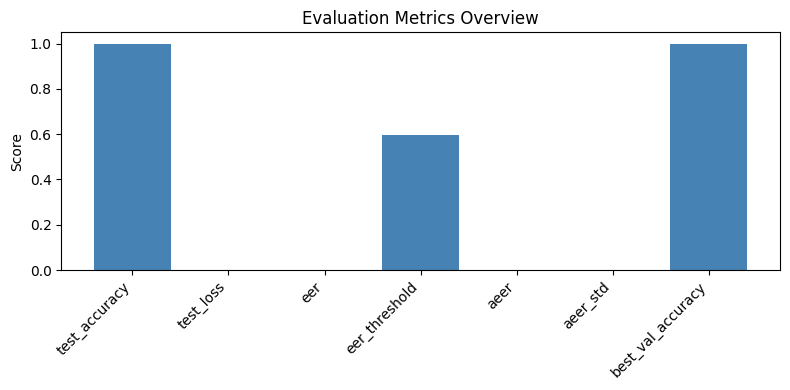

In [29]:
#plotting json data

import os, json, pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

results_path = "/content/drive/MyDrive/CombinedDataset/results_resnet18/metrics.json"

if not os.path.exists(results_path):
    raise FileNotFoundError(f"Metrics file not found at: {results_path}")

with open(results_path, "r") as f:
    metrics = json.load(f)


print("MODEL EVALUATION RESULTS")
pprint.pprint(metrics)


#
df = pd.DataFrame([metrics]).T
df.columns = ["Value"]

#conversation safe
def safe_value(v):
    if isinstance(v, (int, float)):
        return v
    elif isinstance(v, list):
        #take mean if list of numbers
        try:
            return np.mean([float(x) for x in v])
        except:
            return np.nan
    else:
        return np.nan  #skip dicts or other types

df["Value"] = df["Value"].apply(safe_value)

display(df)

df_plot = df.dropna()  #only numeric values

plt.figure(figsize=(8,4))
plt.bar(df_plot.index, df_plot["Value"], color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Evaluation Metrics Overview")
plt.tight_layout()
plt.show()


Confusion Matrix (raw):
[[1309    1]
 [   0 1115]]


,Class 0,Class 1
Class 0,1309,1
Class 1,0,1115


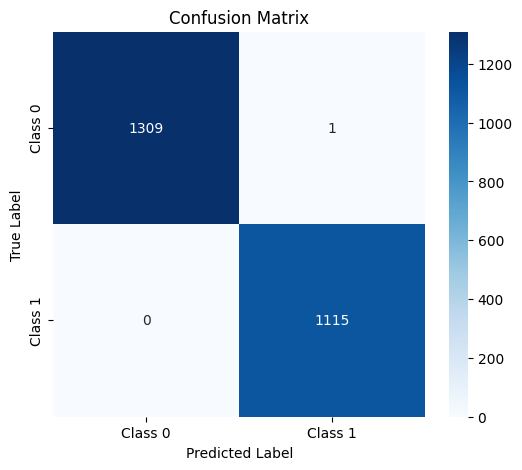

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cm_path = "/content/drive/MyDrive/CombinedDataset/results_resnet18/confusion_matrix.npy"
cm = np.load(cm_path)

print("Confusion Matrix (raw):")
print(cm)

import pandas as pd
df_cm = pd.DataFrame(cm,
                     index=[f"Class {i}" for i in range(cm.shape[0])],
                     columns=[f"Class {i}" for i in range(cm.shape[1])])
display(df_cm)

plt.figure(figsize=(6,5))
sns.heatmap(df_cm, annot=True, fmt=".0f", cmap="Blues")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()


In [32]:
#check which files are duplicated
import os

def get_full_filenames(split, label):
    path = f"/content/drive/MyDrive/CombinedDataset/{split}/mel/{label}"
    return set(os.listdir(path))

train_fake = get_full_filenames('train', 'fake')
val_fake = get_full_filenames('val', 'fake')
test_fake = get_full_filenames('test', 'fake')

print("Duplicated fake files:")
print(f"\nIn both Train and Val: {len(train_fake & val_fake)}")
print("Examples:", list(train_fake & val_fake)[:5])

print(f"\nIn both Train and Test: {len(train_fake & test_fake)}")
print("Examples:", list(train_fake & test_fake)[:5])

print(f"\nIn both Val and Test: {len(val_fake & test_fake)}")
print("Examples:", list(val_fake & test_fake)[:5])

Duplicated fake files:

In both Train and Val: 0
Examples: []

In both Train and Test: 0
Examples: []

In both Val and Test: 0
Examples: []


In [33]:
import os
import shutil
from collections import defaultdict

# Paths
DATA_ROOT = "/content/drive/MyDrive/CombinedDataset"
BACKUP_ROOT = "/content/drive/MyDrive/CombinedDataset_BACKUP"


print("FIXING DATASET SPLITS - REMOVING DUPLICATE FAKE FILES")


# Step 1: Create backup
print("\n1. Creating backup of original dataset")
print(f"   Backup location: {BACKUP_ROOT}")

if not os.path.exists(BACKUP_ROOT):
    response = input("Create backup before fixing? (HIGHLY RECOMMENDED) (y/n): ")
    if response.lower() == 'y':
        print("Copying")
        shutil.copytree(DATA_ROOT, BACKUP_ROOT)
        print(" Backup created successfully")
    else:
        print(" Proceeding without backup")
else:
    print("Backup already exists")

# Step 2: Analyze current state
print("\n2. Analyzing current dataset")

def get_files(split, label):
    path = os.path.join(DATA_ROOT, split, "mel", label)
    return set(os.listdir(path))

train_real = get_files('train', 'real')
val_real = get_files('val', 'real')
test_real = get_files('test', 'real')

train_fake = get_files('train', 'fake')
val_fake = get_files('val', 'fake')
test_fake = get_files('test', 'fake')

print("\nCurrent counts:")
print(f"   Train: {len(train_real)} real, {len(train_fake)} fake")
print(f"   Val:   {len(val_real)} real, {len(val_fake)} fake")
print(f"   Test:  {len(test_real)} real, {len(test_fake)} fake")

print("\nOverlaps in FAKE files:")
train_val_overlap = train_fake & val_fake
train_test_overlap = train_fake & test_fake
val_test_overlap = val_fake & test_fake

print(f"   Train ∩ Val:  {len(train_val_overlap)} files")
print(f"   Train ∩ Test: {len(train_test_overlap)} files")
print(f"   Val ∩ Test:   {len(val_test_overlap)} files")

# Step 3: Strategy - Keep files in Train, remove from Val/Test
print("\n3. Fix strategy:")
print("   Priority: Train > Val > Test")
print("   - Files in Train stay in Train")
print("   - Overlapping files removed from Val and Test")
print("   - Files unique to Val stay in Val")
print("   - Files unique to Test stay in Test")

# Calculate what will be removed
remove_from_val = train_val_overlap
remove_from_test = train_test_overlap | val_test_overlap

print(f"\n Will remove {len(remove_from_val)} files from Val")
print(f"   Will remove {len(remove_from_test)} files from Test")

# Calculate final counts
final_val_fake = len(val_fake) - len(remove_from_val)
final_test_fake = len(test_fake) - len(remove_from_test)

print(f"\nFinal counts after fix:")
print(f"   Train: {len(train_real)} real, {len(train_fake)} fake (unchanged)")
print(f"   Val:   {len(val_real)} real, {final_val_fake} fake (removed {len(remove_from_val)})")
print(f"   Test:  {len(test_real)} real, {final_test_fake} fake (removed {len(remove_from_test)})")

# Check if splits are too imbalanced
val_imbalance = abs(len(val_real) - final_val_fake) / len(val_real) * 100
test_imbalance = abs(len(test_real) - final_test_fake) / len(test_real) * 100

print(f"\nClass imbalance after fix:")
print(f"   Val:  {val_imbalance:.1f}% imbalance (Real: {len(val_real)}, Fake: {final_val_fake})")
print(f"   Test: {test_imbalance:.1f}% imbalance (Real: {len(test_real)}, Fake: {final_test_fake})")

if val_imbalance > 20 or test_imbalance > 20:
    print("\n WARNING: Significant class imbalance detected!")
    print("   Consider regenerating your dataset with proper splits")

# Step 4: Apply fix
print("\n4. Ready to apply fix")
response = input("\nProceed with removing duplicate files? (y/n): ")

if response.lower() != 'y':
    print("Aborted. No changes made.")
    exit()

print("\nRemoving duplicates")

# Remove from Val
val_fake_path = os.path.join(DATA_ROOT, "val", "mel", "fake")
removed_val = 0
for file in remove_from_val:
    file_path = os.path.join(val_fake_path, file)
    if os.path.exists(file_path):
        os.remove(file_path)
        removed_val += 1

print(f"Removed {removed_val} files from Val")

# Remove from Test
test_fake_path = os.path.join(DATA_ROOT, "test", "mel", "fake")
removed_test = 0
for file in remove_from_test:
    file_path = os.path.join(test_fake_path, file)
    if os.path.exists(file_path):
        os.remove(file_path)
        removed_test += 1

print(f"Removed {removed_test} files from Test")

# Step 5: Verify fix
print("\n5. Verifying fix")

train_fake_new = get_files('train', 'fake')
val_fake_new = get_files('val', 'fake')
test_fake_new = get_files('test', 'fake')

overlaps_remain = []
if len(train_fake_new & val_fake_new) > 0:
    overlaps_remain.append(f"Train ∩ Val: {len(train_fake_new & val_fake_new)}")
if len(train_fake_new & test_fake_new) > 0:
    overlaps_remain.append(f"Train ∩ Test: {len(train_fake_new & test_fake_new)}")
if len(val_fake_new & test_fake_new) > 0:
    overlaps_remain.append(f"Val ∩ Test: {len(val_fake_new & test_fake_new)}")

if len(overlaps_remain) > 0:
    print("WARNING: Overlaps still exist:")
    for overlap in overlaps_remain:
        print(f"      {overlap}")
else:
    print("No overlaps detected in fake files")

print("\nFinal dataset counts:")
print(f"   Train: {len(train_real)} real, {len(train_fake_new)} fake")
print(f"   Val:   {len(val_real)} real, {len(val_fake_new)} fake")
print(f"   Test:  {len(test_real)} real, {len(test_fake_new)} fake")


print("DATASET FIX COMPLETE")

print("\nNext steps:")
print("1. Re-run your training code")
print("2. Expect lower accuracy (70-95%) - this is realistic")
print("3. If class imbalance is too high, consider:")
print("   - Regenerating dataset with proper splits")
print("   - Using class weights in training")
print(f"\nBackup location: {BACKUP_ROOT}")
print("(You can restore from backup if needed)")

FIXING DATASET SPLITS - REMOVING DUPLICATE FAKE FILES

1. Creating backup of original dataset
   Backup location: /content/drive/MyDrive/CombinedDataset_BACKUP
Backup already exists

2. Analyzing current dataset

Current counts:
   Train: 10480 real, 10480 fake
   Val:   1310 real, 1120 fake
   Test:  1310 real, 1115 fake

Overlaps in FAKE files:
   Train ∩ Val:  0 files
   Train ∩ Test: 0 files
   Val ∩ Test:   0 files

3. Fix strategy:
   Priority: Train > Val > Test
   - Files in Train stay in Train
   - Overlapping files removed from Val and Test
   - Files unique to Val stay in Val
   - Files unique to Test stay in Test

 Will remove 0 files from Val
   Will remove 0 files from Test

Final counts after fix:
   Train: 10480 real, 10480 fake (unchanged)
   Val:   1310 real, 1120 fake (removed 0)
   Test:  1310 real, 1115 fake (removed 0)

Class imbalance after fix:
   Val:  14.5% imbalance (Real: 1310, Fake: 1120)
   Test: 14.9% imbalance (Real: 1310, Fake: 1115)

4. Ready to apply 